# # Finding patterns, similarities and trends in stock data.

In [50]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from pandas import tseries
from dateutil import relativedelta
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.api import qqplot
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import re

matplotlib.rc("image",cmap="gray")
plt.rcParams['figure.figsize'] = (17, 20)
plt.style.use('ggplot')


#Making matplot plot inline
%matplotlib inline

Step 1: Explore the data, find the time covered by this stock dataset.

In [3]:
#Read the data and print out information about the data.
stocks_data = pd.read_csv("data_stocks.csv")
#display few rows to get a sense of the data.
print(stocks_data.head())
#get the column names and data type and number of rows
print(stocks_data.info())
#print the columns
print(list(stocks_data))

#Changing the date to human-readable format
first_row = stocks_data.iloc[[0]]
last_row = stocks_data.iloc[[41265]]
date1 = stocks_data['DATE'].iloc[0]
date2 = stocks_data['DATE'].iloc[-1]
#utc_time = datetime.utcfromtimestamp(date1)
print(datetime.datetime.utcfromtimestamp(date1).strftime('%Y-%m-%d %H:%M:%S'))
print(datetime.datetime.utcfromtimestamp(date2).strftime('%Y-%m-%d %H:%M:%S'))
#stocks_data['DATE']=(pd.to_datetime(stocks_data['DATE'],unit='ns', utc=True, infer_datetime_format = True)) 
#stocks_data['DATE']=pd.to_datetime(stocks_data['DATE'], utc=False)

#Convert the column to date type from integer - generate date from unix timestamp
stocks_data['DATE'] = stocks_data['DATE'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))
#stocks_data['DATE'] = stocks_data['DATE'].apply(lambda x: x.date())
stocks_data.index = pd.to_datetime(stocks_data.index, unit='s')

#Find the total time covered in this dataset.
print(stocks_data['DATE'].iloc[0], stocks_data['DATE'].iloc[-1])
difference = relativedelta.relativedelta(stocks_data['DATE'].iloc[-1], stocks_data['DATE'].iloc[0])
print("Difference in time between the first and last entries in the dataset ",difference)
print("Time range covered by this dataset in days: ",(stocks_data['DATE'].iloc[-1] - stocks_data['DATE'].iloc[0]).days)

         DATE      SP500  NASDAQ.AAL  NASDAQ.AAPL  NASDAQ.ADBE  NASDAQ.ADI  \
0  1491226200  2363.6101     42.3300     143.6800     129.6300      82.040   
1  1491226260  2364.1001     42.3600     143.7000     130.3200      82.080   
2  1491226320  2362.6799     42.3100     143.6901     130.2250      82.030   
3  1491226380  2364.3101     42.3700     143.6400     130.0729      82.000   
4  1491226440  2364.8501     42.5378     143.6600     129.8800      82.035   

   NASDAQ.ADP  NASDAQ.ADSK  NASDAQ.AKAM  NASDAQ.ALXN    ...     NYSE.WYN  \
0    102.2300      85.2200       59.760       121.52    ...       84.370   
1    102.1400      85.6500       59.840       121.48    ...       84.370   
2    102.2125      85.5100       59.795       121.93    ...       84.585   
3    102.1400      85.4872       59.620       121.44    ...       84.460   
4    102.0600      85.7001       59.620       121.60    ...       84.470   

   NYSE.XEC  NYSE.XEL  NYSE.XL  NYSE.XOM  NYSE.XRX  NYSE.XYL  NYSE.YUM  \


Step 2: Let's resample the data and make it more manageable. Average seems to be a good approximator.

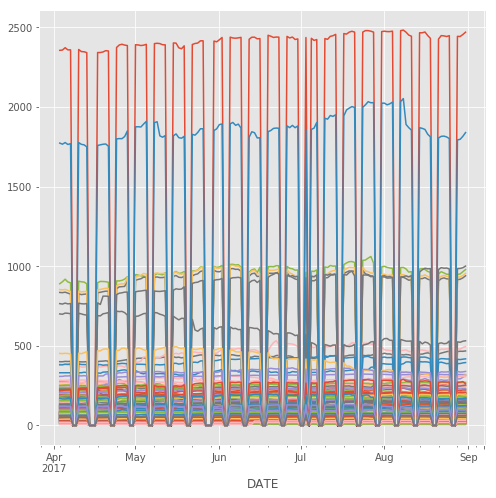

In [90]:
dly = stocks_data.resample('D', on='DATE').mean().fillna(0)

dly.plot(figsize=(8,8), legend=None)
plt.show()

Step 3. Let's see how the stock prices change. Let's start with change on a daily basis.

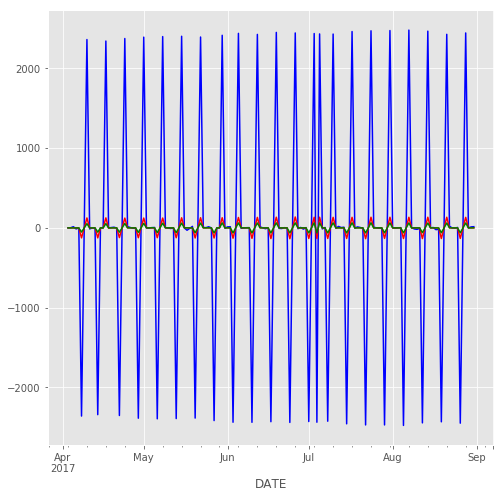

In [91]:
#Variations across days.
pct_chg = (dly - dly.shift()).fillna(0)

#Let's plot changes for randomly chosen 3 stocks.

pct_chg['SP500'].plot(figsize=(8,8), legend=None, c = 'blue')
pct_chg['NYSE.JNJ'].plot(figsize=(8,8), legend=None, c = 'red')
pct_chg['NYSE.ZTS'].plot(figsize=(8,8), legend=None, c = 'green')
plt.show()

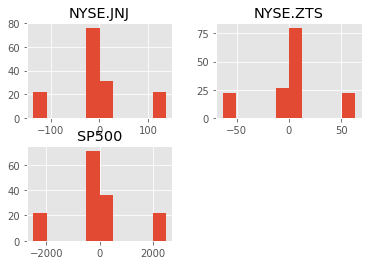

In [52]:
pct_chg[['SP500','NYSE.JNJ','NYSE.ZTS']].hist(bins=10)
plt.show()

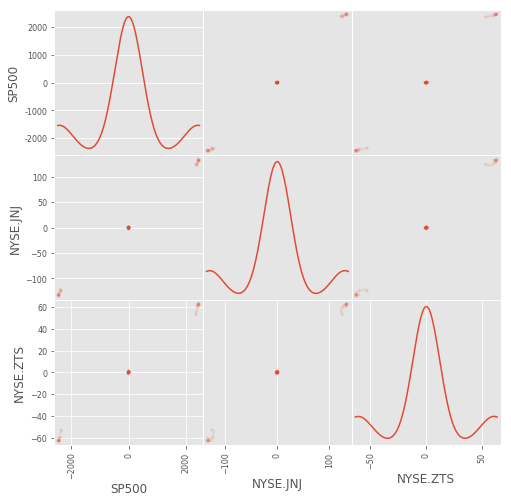

In [92]:
pd.plotting.scatter_matrix(pct_chg[['SP500','NYSE.JNJ','NYSE.ZTS']], diagonal='kde', alpha=0.1,figsize=(8,8))
plt.show()

Step 4: Separating stocks as SP500, NASDAQ, NYSE

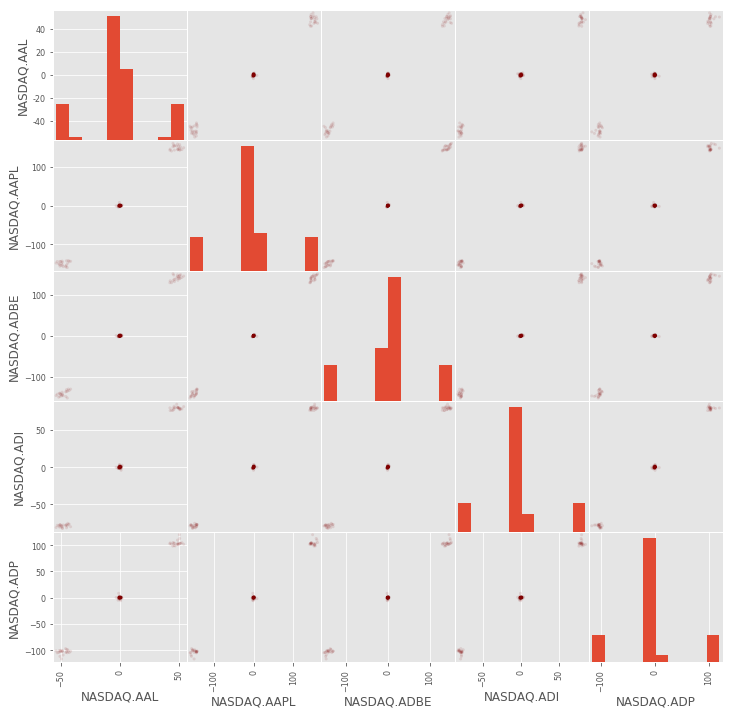

In [53]:
NASDAQ_list = [x for x in list(dly) if 'NASDAQ' in (x)]
NYSE_list = [x for x in list(dly) if 'NYSE' in (x)]

pd.plotting.scatter_matrix(pct_chg[NASDAQ_list[0:5]], alpha=0.1,figsize=(12,12), color = 'maroon')
plt.show()

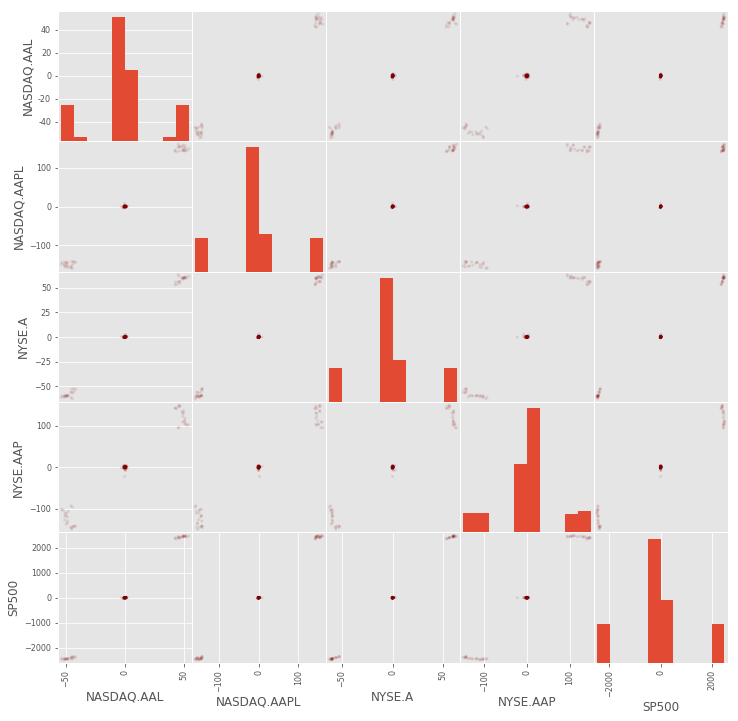

In [34]:
sample = NASDAQ_list[0:2] + NYSE_list[0:2] + ['SP500']
pd.plotting.scatter_matrix(pct_chg[list(sample)], alpha=0.1,figsize=(12,12), color = 'maroon')
plt.show()

Step 5: Not much correlation found among these chosen stocks. Moving on to calculating rolling statistics based on 7 days.

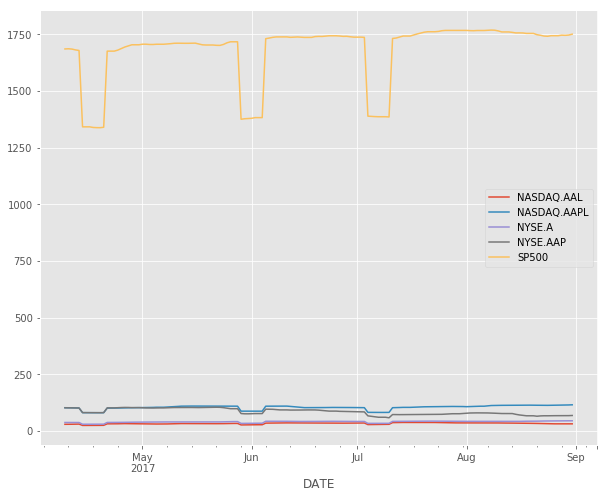

In [54]:
moving_avg = dly.rolling(window=7).mean()
moving_avg[sample].plot(figsize=(10, 8))
plt.show()

Step 6: Find volatility

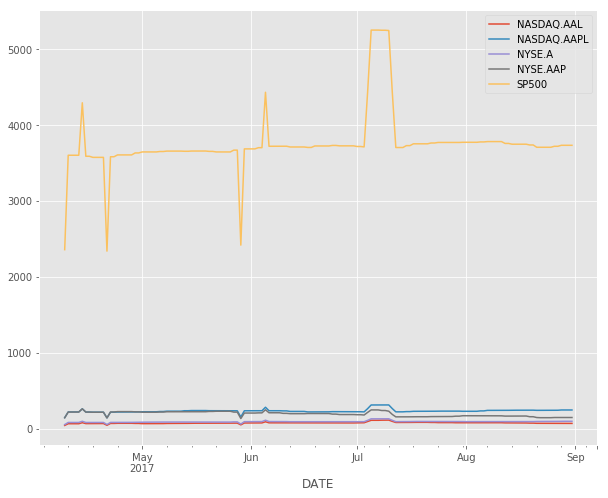

In [55]:
# Define the minumum of periods to consider 
min_periods = 7

# Calculate the volatility
vol = pct_chg.rolling(min_periods).std() * np.sqrt(min_periods) 

# Plot the volatility
vol[sample].plot(figsize=(10, 8))

# Show the plot
plt.show()


Step 7: Plot Elbow curve to find number of clusters.

Text(0.5,1,'Elbow curve')

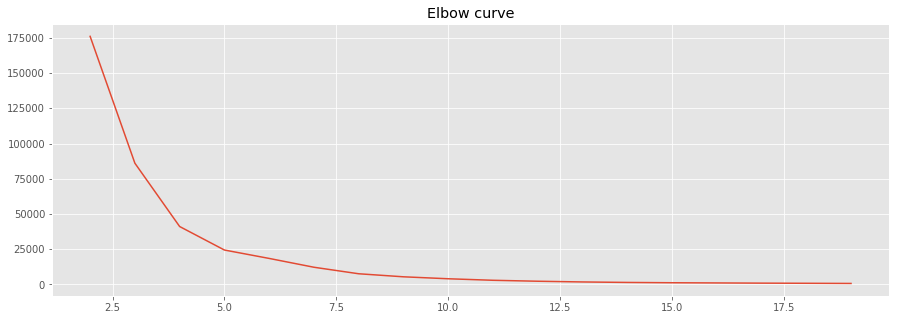

In [85]:
returns = (dly - dly.shift(1)).fillna(0).mean() * 1
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = (dly - dly.shift(7)).fillna(0).std() * np.sqrt(1)
 
#format the data as a numpy array to feed into the K-Means algorithm
data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T
 
X = data
distorsions = []
for k in range(2, 20):
    k_means = KMeans(n_clusters=k)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
 
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

Step 8: Down-sampling definitely helps us in dealing with this huge dataset. Also let's switch row/column, describe each stock's data for 150 days by means of descriptive statistics and use that for clustering.

In [74]:
mean_list = ((stocks_data.resample('Y', on='DATE').mean()).values).transpose().squeeze()
std_list = ((stocks_data.resample('Y', on='DATE').std()).values).transpose().squeeze()
min_list = stocks_data.resample('Y', on='DATE').min()
min_list.drop('DATE', axis = 1, inplace = True)
min_list = (min_list.values).transpose().squeeze()
max_list = stocks_data.resample('Y', on='DATE').max()
max_list.drop('DATE', axis = 1, inplace = True)
max_list = (max_list.values).transpose().squeeze()
q1_list = ((stocks_data.resample('Y', on='DATE').quantile(0.25)).values).transpose().tolist()
q2_list = ((stocks_data.resample('Y', on='DATE').quantile(0.50)).values).transpose().tolist()
q3_list = ((stocks_data.resample('Y', on='DATE').quantile(0.75)).values).transpose().tolist()

range_list = list(map(lambda x,y: abs(x - y), max_list, min_list))

stats = pd.DataFrame({'Mean': mean_list, 'SD': std_list, 'Range': range_list})
print(stats.shape)

C:\Users\Monica\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
.resample() is now a deferred operation
You called quantile(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  if __name__ == '__main__':
C:\Users\Monica\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 
.resample() is now a deferred operation
You called quantile(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  # Remove the CWD from sys.path while we load stuff.


(501, 3)


C:\Users\Monica\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: 
.resample() is now a deferred operation
You called quantile(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  # This is added back by InteractiveShellApp.init_path()


Step 9: Use K-Means over the descriptive statistics to find the clusters.

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


Text(0.5,0,'Range')

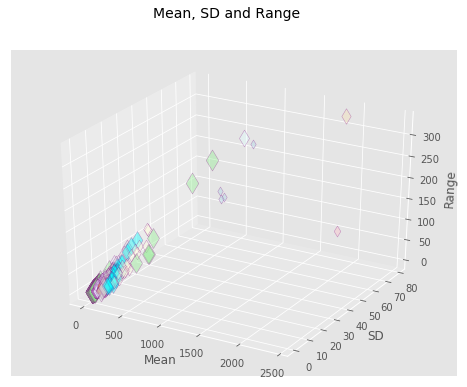

In [86]:
# Initializing KMeans
num_clusters = 12
kmeans = KMeans(n_clusters=num_clusters)
# Fitting with inputs
model = kmeans.fit(stats.values)
# Predicting the clusters
labels = model.predict(stats.values)
# Getting the cluster centers
Centers = (kmeans.cluster_centers_).tolist()
Labels = kmeans.labels_.tolist()
#printing unique elements in list
print(set(Labels))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
t = fig.suptitle('Mean, SD and Range', fontsize=14)

xs = list(stats['Mean'])
ys = list(stats['SD'])
zs = list(stats['Range'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]

ss = Labels 
colors = [ 'orange' if l == 0 else 'lightblue' if l == 1 else 'pink' if l == 2 else \
          'lightyellow' if l == 3 else 'lavender' if l == 4 else 'wheat' if l == 5 else 'lightcyan' if l == 6 else \
          'cyan' if l == 7 else 'lightgrey' if l == 8 else 'lightgreen' for l in Labels]

for data, color, size in zip(data_points, colors, ss):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='purple', s=(size+1) * 20, marker = 'd') # + 1 to compensate for label being 0

ax.set_xlabel('Mean')
ax.set_ylabel('SD')
ax.set_zlabel('Range')

2D Plot

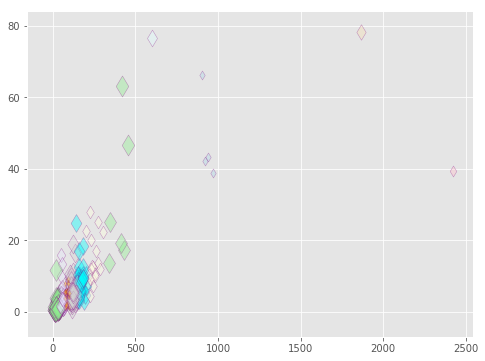

In [88]:
#2-D plot
fig = plt.figure(figsize=(8, 6))
data_2d = [(x, y) for x, y in zip(xs, ys)]

for data, color, size in zip(data_2d, colors, ss):
    x, y = data
    plt.scatter(x, y, alpha=0.4, c=color, edgecolors='purple', s=(size+1) * 20, marker = 'd') # + 1 to compensate for label being 0

plt.show()

Step 10: Find correlation to find which stocks vary together and not.

In [96]:
ln_diff = pd.DataFrame()
stocks = list(dly)
#stocks = stocks.remove('DATE')
for col in stocks:
    ln_diff[col] = np.log(dly[col].diff())
    
#From stackoverflow, List Highest Correlation Pairs from a Large Correlation Matrix in Pandas?   
    
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop    
    
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_least_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(ln_diff, 501))    

    
    

C:\Users\Monica\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\Monica\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


Top Absolute Correlations
NASDAQ.GOOG   NASDAQ.GOOGL    0.995155
NASDAQ.DISCA  NASDAQ.DISCK    0.994180
NYSE.BHI      NYSE.SO         0.993755
NYSE.CHD      NYSE.PFE        0.993103
NASDAQ.FOX    NASDAQ.FOXA     0.992899
NYSE.CTL      NYSE.LVLT       0.992495
NASDAQ.INFO   NYSE.BHI        0.991117
NYSE.NBL      NYSE.TMK        0.990327
NYSE.FLR      NYSE.LOW        0.990227
NYSE.DHR      NYSE.WFC        0.989079
NASDAQ.FOXA   NYSE.CBG        0.988875
NYSE.KMI      NYSE.VNO        0.988516
NYSE.MMC      NYSE.VLO        0.988426
NYSE.DD       NYSE.DOW        0.988372
NASDAQ.NWS    NASDAQ.NWSA     0.988366
NYSE.GWW      NYSE.HOG        0.988019
NYSE.NBL      NYSE.STI        0.987883
NASDAQ.MAT    NYSE.NOV        0.987769
NYSE.HOG      NYSE.XOM        0.987588
NASDAQ.FOXA   NYSE.GPN        0.987500
NASDAQ.DISCA  NYSE.PNR        0.987405
NYSE.CLX      NYSE.FTI        0.987267
NYSE.ETN      NYSE.L          0.987147
NYSE.LYB      NYSE.NI         0.987109
NYSE.BBT      NYSE.NBL        0.986932

In [97]:
print("Least Absolute Correlations")
print(get_least_abs_correlations(ln_diff, 501)) 

Least Absolute Correlations
NASDAQ.CERN  NYSE.XRX       0.715211
NASDAQ.LRCX  NASDAQ.SPLS    0.726580
NYSE.LB      NYSE.NEM       0.728695
NYSE.COL     NYSE.LB        0.730693
NYSE.LB      NYSE.VMC       0.731878
NASDAQ.MU    NYSE.XRX       0.735714
NYSE.LB      NYSE.RHI       0.737743
             NYSE.MAS       0.737790
             NYSE.MAA       0.738573
NASDAQ.CSX   NYSE.LB        0.739189
NYSE.LB      NYSE.MLM       0.740060
NASDAQ.LRCX  NYSE.LB        0.740762
NYSE.ALK     NYSE.LB        0.741467
NYSE.LB      NYSE.LMT       0.742862
NYSE.JCI     NYSE.LB        0.743250
NASDAQ.AAL   NYSE.LB        0.744357
NASDAQ.ORLY  NYSE.LB        0.744631
NYSE.LB      NYSE.SWK       0.746506
NYSE.IVZ     NYSE.XRX       0.750769
NYSE.JCI     NYSE.XRX       0.753043
NYSE.MAA     NYSE.XRX       0.754003
NYSE.CNP     NYSE.LB        0.755326
NYSE.HON     NYSE.LB        0.759088
NYSE.GPC     NYSE.LB        0.759298
NYSE.LB      NYSE.TDG       0.759960
NYSE.CPB     NYSE.LB        0.759973
NYSE.EQT  